In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [2]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [3]:
DOWN = '*down.csv'
UP = '*up.csv'
N_TYPE = 'Type'
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TRANSF_TIME = 'Transfer Time (s)'
N_DATA_SIZES = 'Data Sizes (MB)'
N_OUTLIERS = 'Outliers'
FOLDER = 'output/SCP'

In [7]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_theme("paper", style='whitegrid', color_codes=True, 
              rc=common.sns_params, palette='bright')

In [98]:
src_dirs = []
for folder in glob.glob('data/starlink-data/SCP/*'):
    src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/SCP/*'):
    src_dirs.append(('Home', folder))
src_dirs

[('Starlink', 'data/starlink-data/SCP/2022-06-06_starlink_measures_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-05_starlink_measure_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-21_starlink_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-21_starlink_measures_scp'),
 ('Starlink', 'data/starlink-data/SCP/2022-06-06_starlink_scp'),
 ('Home', 'data/Home_network_data/SCP/2022-06-21_trad_measures_scp'),
 ('Home', 'data/Home_network_data/SCP/2022-06-06_trad_measures_scp')]

In [99]:
pattern = DOWN
df = pd.DataFrame()
for type_name, folder in src_dirs:
    files = glob.glob(f"{folder}/**/{pattern}", recursive=True)
    df_temp = pd.concat([pd.read_csv(f, index_col=False) for f in files])
    df_temp.rename(columns={'timestamp': N_TIMESTAMP, 'region': N_REGIONS}, inplace=True)
    
    df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
    df_temp = df_temp.melt([N_TIMESTAMP, N_REGIONS], var_name=N_DATA_SIZES, value_name=N_TRANSF_TIME)
    
    df_temp[N_TYPE] = type_name
    if not df.empty:
        df = df.merge(df_temp, how='outer')
    else:
        df = df_temp
df.dropna(how='all', inplace=True)
df[N_REGIONS] = df[N_REGIONS].map(common.REGION_MAP)
df[N_DATA_SIZES] = df[N_DATA_SIZES].str.removesuffix('MB').astype(int)
#df_regs_interp['sort_name'] = df_regs_interp[N_DATA_SIZES].str.pad(6, 'left', '0')
df.sort_values([N_REGIONS, N_TYPE], inplace=True, ignore_index=True)
#df_regs_interp = df_regs_interp.drop('sort_name', axis=1)
df = df.drop(df[df[N_DATA_SIZES] == 500].index)
#df[df[N_REGIONS] == 'Singapore'].sort_values(N_TRANSF_TIME).to_csv(f'{FOLDER}/out_scp.csv')
df

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type
0,2022-06-22 11:23:02,Bahrain,1,5.574,Home
1,2022-06-22 15:17:09,Bahrain,1,5.162,Home
2,2022-06-22 19:15:04,Bahrain,1,5.175,Home
3,2022-06-22 23:18:38,Bahrain,1,5.236,Home
4,2022-06-23 03:14:52,Bahrain,1,6.625,Home
...,...,...,...,...,...
2605,2022-06-06 11:15:00,Tokyo,1,4.034,Starlink
2606,2022-06-06 11:15:00,Tokyo,10,4.728,Starlink
2607,2022-06-06 11:15:00,Tokyo,100,20.563,Starlink
2608,2022-06-06 11:15:00,Tokyo,200,104.328,Starlink


In [ ]:
df[df[N_TYPE] == 

In [54]:
# Filter out outliers
df_outliers = df.copy()
zscore = np.abs(
    df_outliers.groupby([
        N_TYPE, N_REGIONS, N_DATA_SIZES
    ])[N_TRANSF_TIME].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_OUTLIERS] = (np.abs(zscore) >= 3)
df_outliers

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type,Outliers
0,2022-06-22 11:23:02,Bahrain,1,5.574,Home,False
1,2022-06-22 15:17:09,Bahrain,1,5.162,Home,False
2,2022-06-22 19:15:04,Bahrain,1,5.175,Home,False
3,2022-06-22 23:18:38,Bahrain,1,5.236,Home,False
4,2022-06-23 03:14:52,Bahrain,1,6.625,Home,False
...,...,...,...,...,...,...
2605,2022-06-06 11:15:00,Tokyo,1,4.034,Starlink,False
2606,2022-06-06 11:15:00,Tokyo,10,4.728,Starlink,False
2607,2022-06-06 11:15:00,Tokyo,100,20.563,Starlink,False
2608,2022-06-06 11:15:00,Tokyo,200,104.328,Starlink,False


In [11]:
df_outliers = df[(np.abs(stats.zscore(df[N_TRANSF_TIME], nan_policy='omit')) >= 3)]
df_outliers.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).mean()
df.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).max().pivot_table(index=N_REGIONS, columns=[N_TYPE, N_DATA_SIZES])
df[df[N_TRANSF_TIME] > 300]
#df.sort_values(N_TIMESTAMP)

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type
493,2022-06-07 02:38:20,Cape Town,300,309.098,Starlink
1633,2022-06-07 01:45:05,Sao Paulo,300,403.818,Starlink
1983,2022-06-22 23:22:48,Singapore,300,961.324,Starlink


In [12]:
# Aggreagation options
df_no_out.to_csv("output/SCP/out_scp_before.csv", encoding='utf-8-sig')
df_regs_interp = df.set_index(N_TIMESTAMP)
#df_regs_interp = df_regs_interp.loc['2022-06-21':]
df_regs_interp = df_regs_interp.groupby([N_TYPE, N_REGIONS, N_DATA_SIZES]).resample('H').mean()
print(df_regs_interp)
#df_regs_interp = df_regs_interp.set_index([N_TYPE, N_REGIONS, N_TIMESTAMP])
df_regs_interp = df_regs_interp.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,11,1))
df_regs_interp = df_regs_interp.reset_index()

df_regs_interp

                                                      Data Sizes (MB)  \
Type     Regions Data Sizes (MB) Timestamp                              
Home     Bahrain 1               2022-06-06 12:00:00              1.0   
                                 2022-06-06 13:00:00              NaN   
                                 2022-06-06 14:00:00              NaN   
                                 2022-06-06 15:00:00              1.0   
                                 2022-06-06 16:00:00              NaN   
...                                                               ...   
Starlink Tokyo   300             2022-06-23 19:00:00            300.0   
                                 2022-06-23 20:00:00              NaN   
                                 2022-06-23 21:00:00              NaN   
                                 2022-06-23 22:00:00              NaN   
                                 2022-06-23 23:00:00            300.0   

                                                  

ValueError: cannot insert Data Sizes (MB), already exists

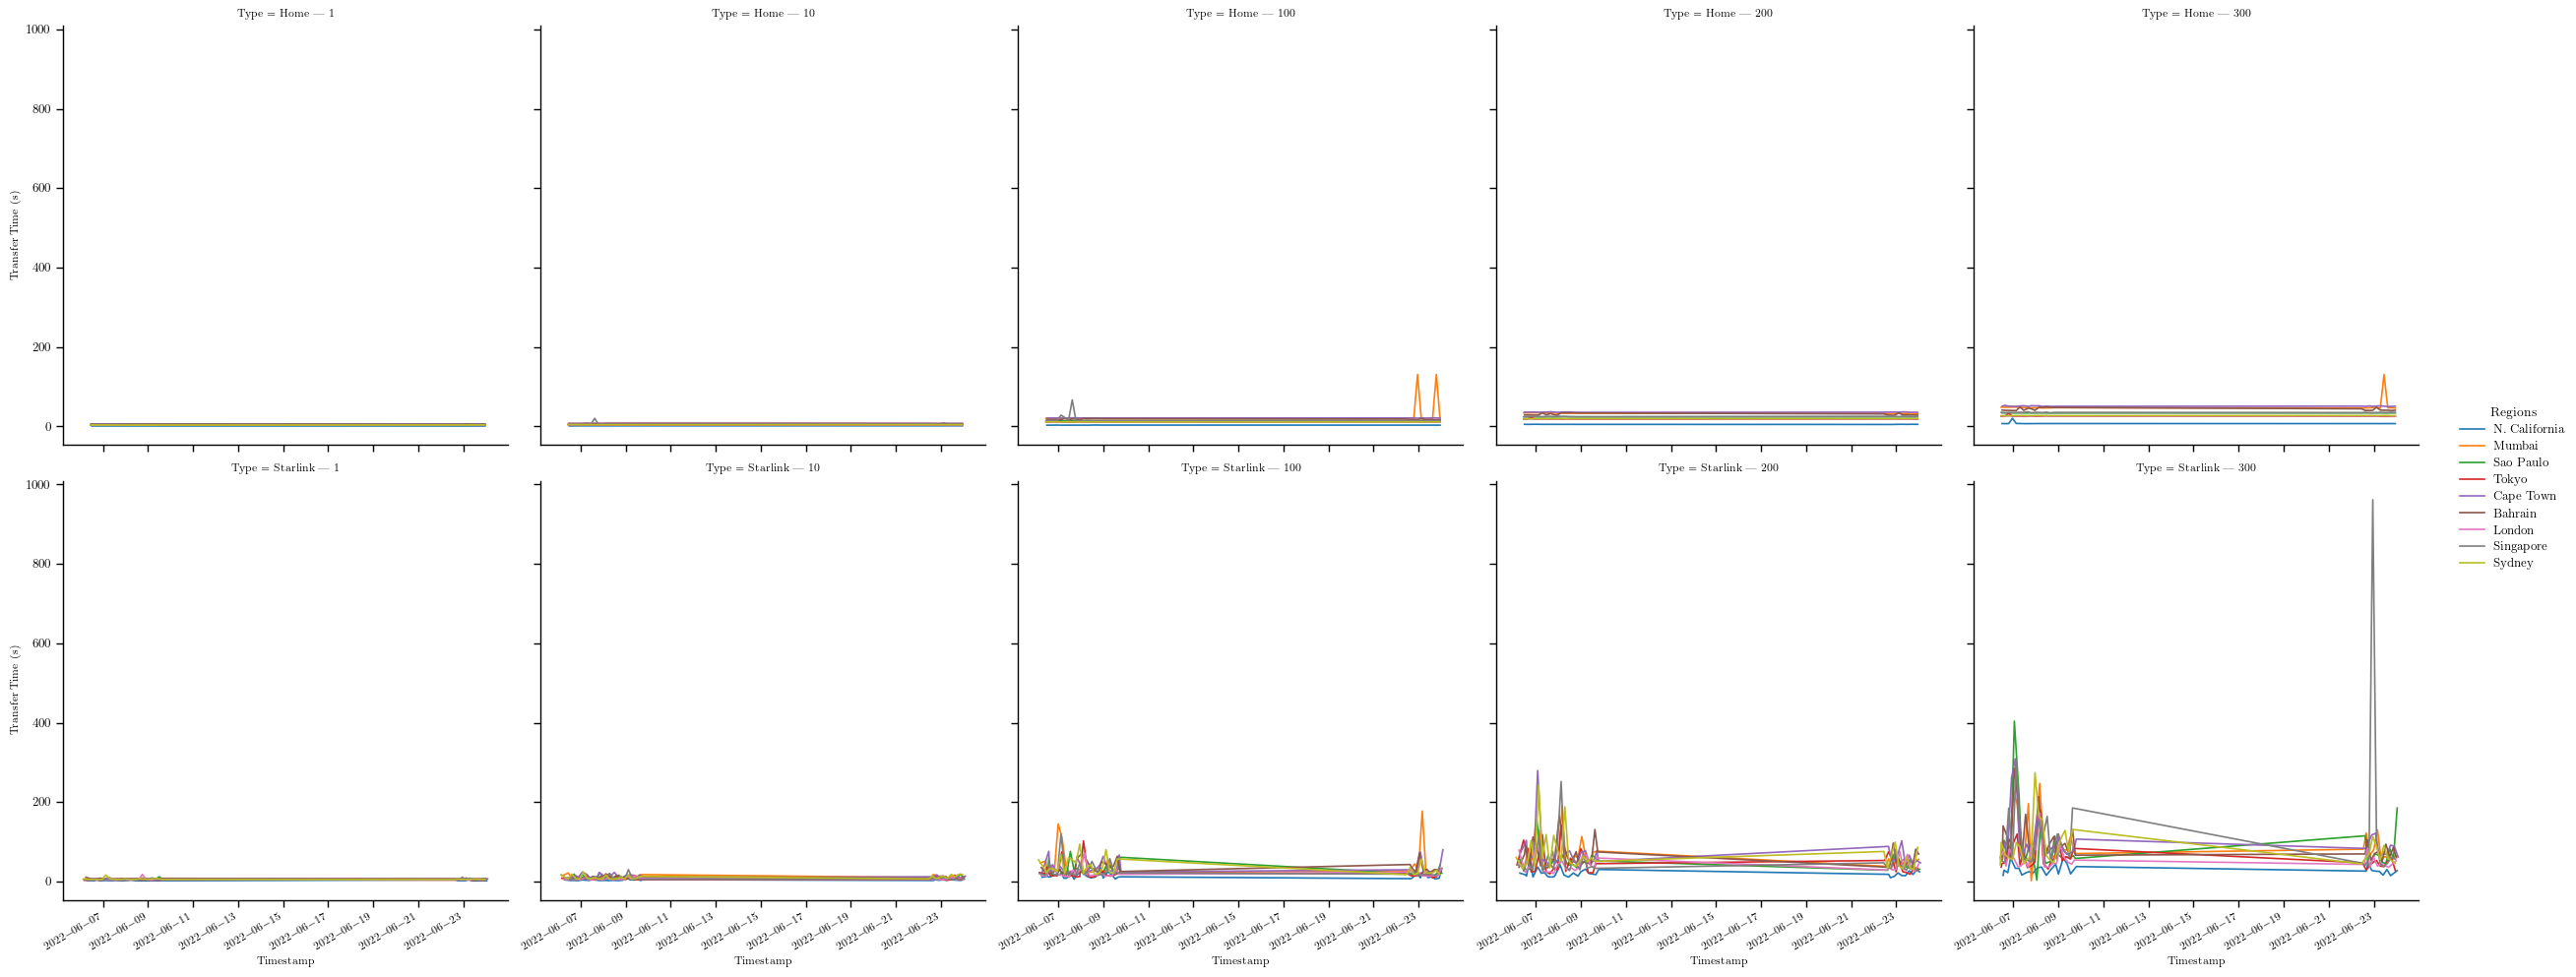

In [19]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

g = sns.relplot(data=df_regs_interp,
                x=N_TIMESTAMP, y=N_TRANSF_TIME,
                kind='line',
                col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, height=5)

#g = sfigurelineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.set_titles(col_template="{col_name}")
g.figure.autofmt_xdate()
g.tight_layout()

#fig.tight_layout()

In [14]:
#g_data = sns.catplot(data=df_regs_interp,
#                x=N_DATA_SIZES, y=N_TRANSF_TIME,
#                kind='bar',
#                col=N_REGIONS, hue=N_TYPE, height=2, aspect=0.716, col_wrap=5)
#
#g_data.set_titles(col_template="{col_name}")
#g_data.tight_layout()
df.dtypes

Timestamp            datetime64[ns]
Regions                      object
Data Sizes (MB)               int64
Transfer Time (s)           float64
Type                         object
dtype: object

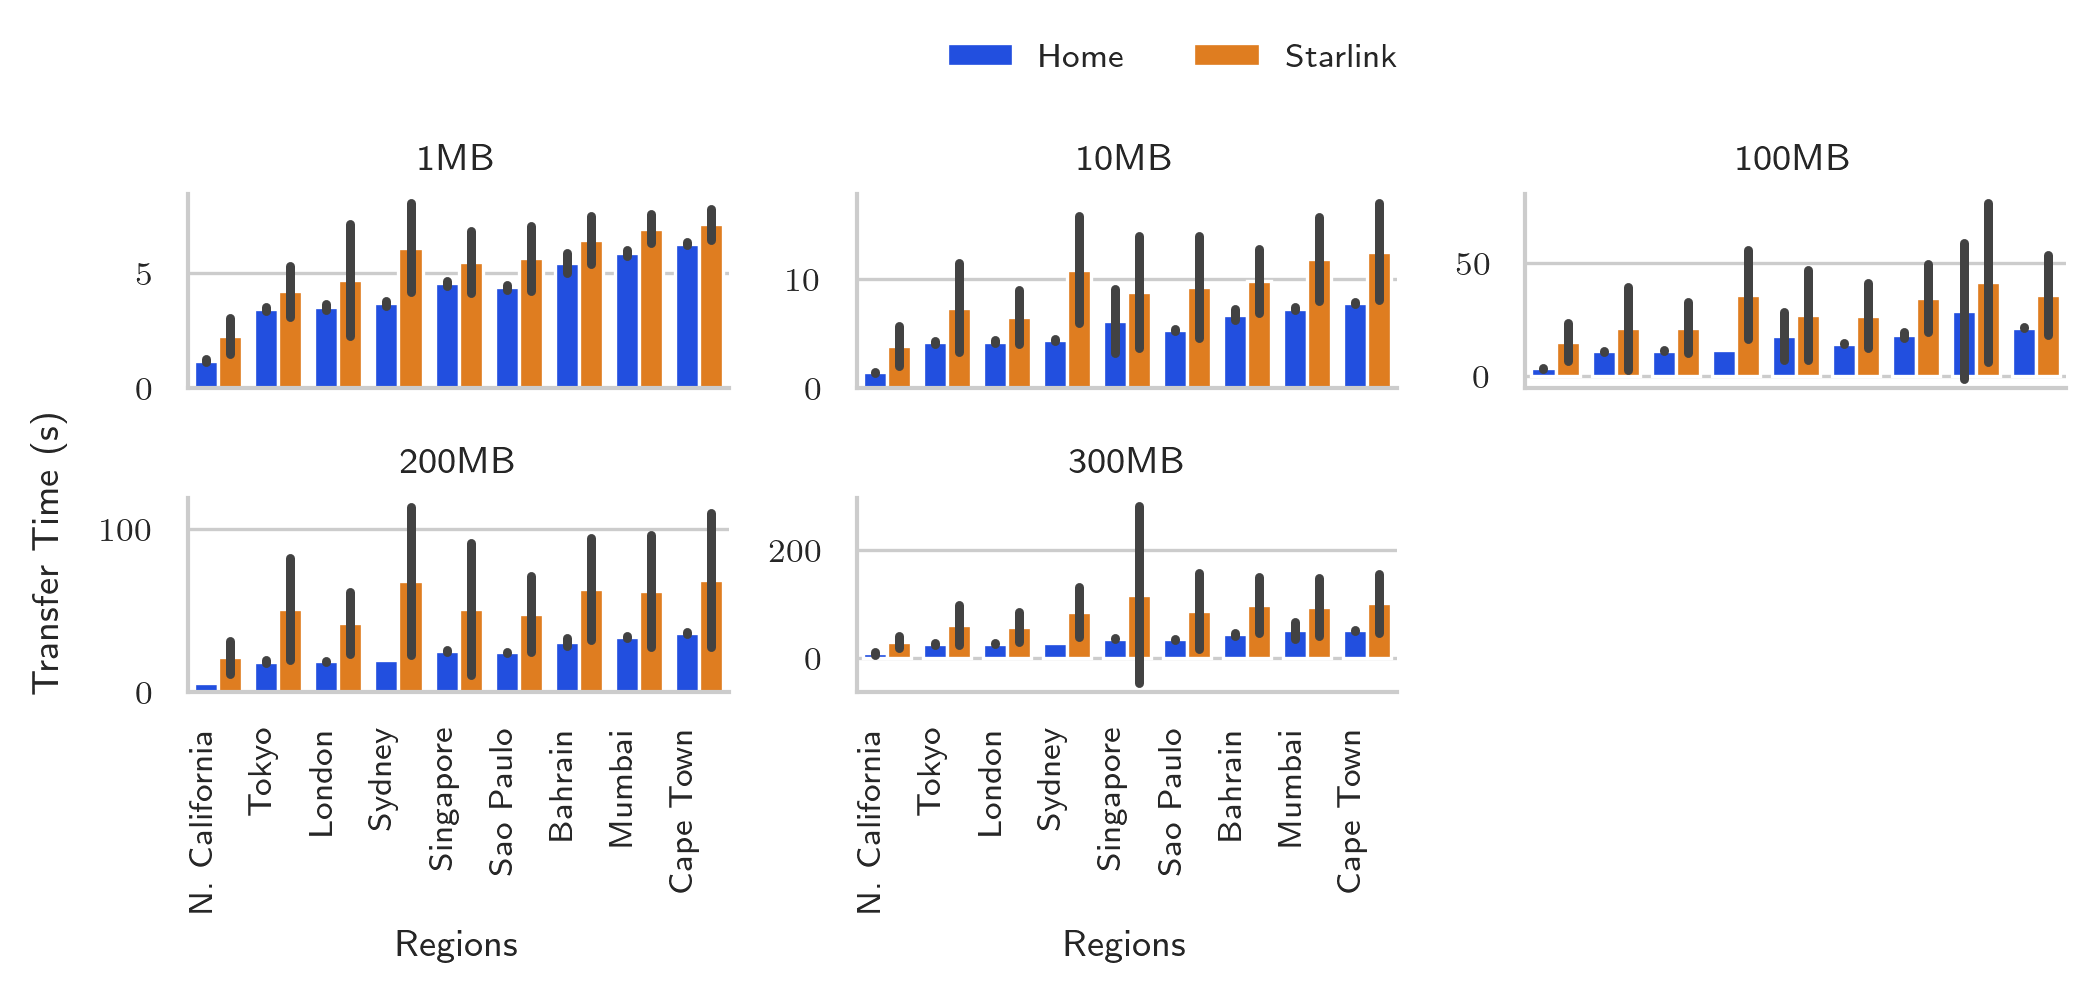

In [96]:
g_data = sns.catplot(
    data=df_outliers,
    x=N_REGIONS, y=N_TRANSF_TIME,
    order=common.REGION_ORDER,
    kind='bar',
    ci='sd',
    sharey=False,
    col=N_DATA_SIZES, hue=N_TYPE, height=1.5, aspect=1.59111, col_wrap=3
)

g_data.set_titles(col_template="{col_name}MB")
g_data.set(
    ylabel='',
    #yscale='log',
)
g_data.figure.supylabel(N_TRANSF_TIME)
axes = g_data.axes.flatten()
sns.move_legend(g_data, loc='lower center',
               bbox_to_anchor=(.5, 1), ncol=3, title=None)
#axes[4].legend(loc='lower left', bbox_to_anchor=(1.04,0))
g_data.figure.autofmt_xdate()
for ax in axes:
    ax.tick_params(axis='x', labelrotation = 90)
g_data.tight_layout()

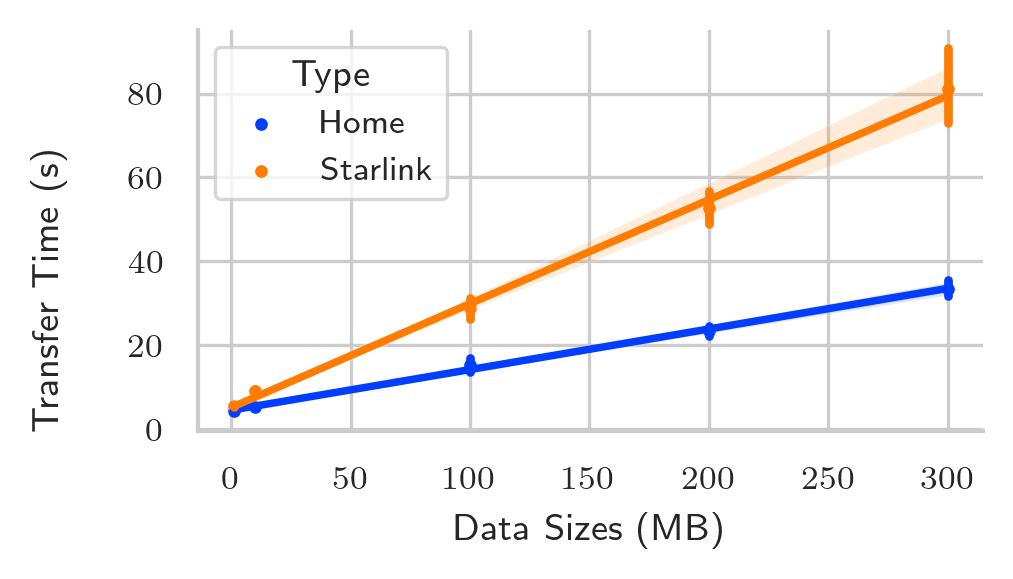

In [94]:
g_regress = sns.lmplot(
    data=df_outliers,
    x=N_DATA_SIZES, y=N_TRANSF_TIME,
    #col=N_DATA_SIZES, 
    #col_wrap=3
    hue=N_TYPE, 
    height=2, aspect=1.69,
    x_estimator=np.mean,
    facet_kws=dict(legend_out=False),
    scatter_kws=dict(s=5),
)

g_regress.set_titles(col_template="{col_name}MB")
g_regress.set(
    ylabel='',
    #yscale='log',
)
g_regress.figure.supylabel(N_TRANSF_TIME)
axes = g_data.axes.flatten()
sns.move_legend(g_data, loc='lower center',
               bbox_to_anchor=(.5, 1), ncol=3, title=None)
#axes[4].legend(loc='lower left', bbox_to_anchor=(1.04,0))
#for ax in axes:
#    ax.tick_params(axis='x', labelrotation = 90)
g_regress.tight_layout()

In [51]:
df_outliers.sort_values(N_TIMESTAMP)

,Timestamp,Regions,Data Sizes (MB),Transfer Time (s),Type,Outliers
2262,2022-06-06 03:42:02,Sydney,100,54.596,Starlink,False
2260,2022-06-06 03:42:02,Sydney,1,6.559,Starlink,False
2261,2022-06-06 03:42:02,Sydney,10,16.777,Starlink,False
2263,2022-06-06 03:42:02,Sydney,200,60.726,Starlink,False
1935,2022-06-06 04:25:56,Singapore,1,4.892,Starlink,False
...,...,...,...,...,...,...
554,2022-06-24 02:04:32,Cape Town,200,46.842,Starlink,False
564,2022-06-24 02:04:32,Cape Town,300,61.539,Starlink,False
524,2022-06-24 02:04:32,Cape Town,1,6.780,Starlink,False
534,2022-06-24 02:04:32,Cape Town,10,13.251,Starlink,False


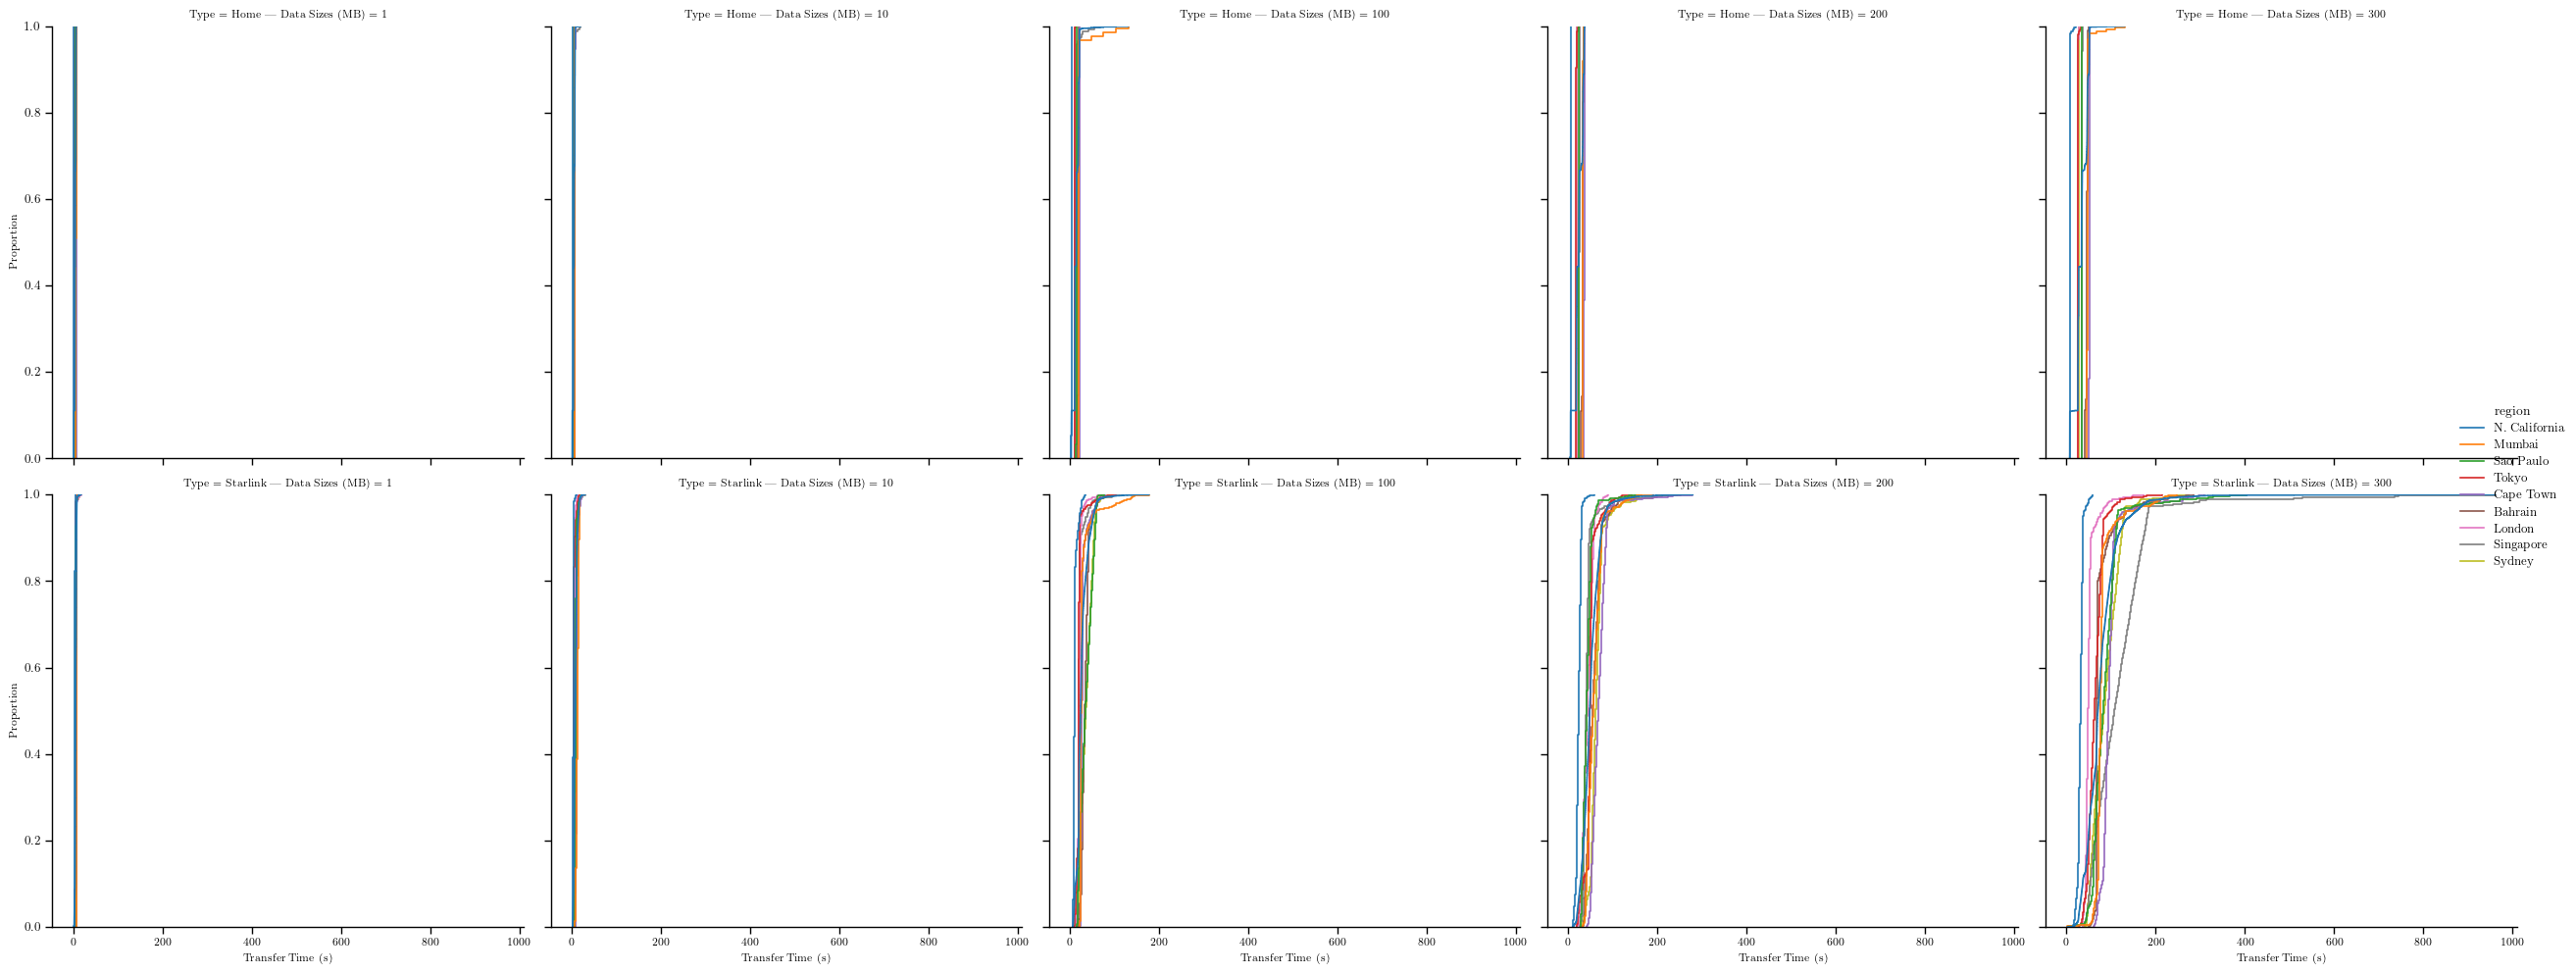

In [12]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.displot(data=df_regs_interp, x=N_TRANSF_TIME, 
                 kind='ecdf',
                 col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, height=5)
g2.map(sns.ecdfplot, N_TRANSF_TIME)
g2.add_legend()
#sns.ecdfplot(data=df_unstacked, x='bandwidth', hue=N_REGIONS)
g2.tight_layout()
#fig2.tight_layout()

In [97]:
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')
g_data.savefig(f'{FOLDER}/2022-06-24_end_scp_summary.pdf', bbox_inches='tight')
g_regress.savefig(f'{FOLDER}/2022-06-24_end_scp_regress.pdf', bbox_inches='tight')
#g2.savefig(f'output/SCP/scp_cdf.pdf', bbox_inches='tight')